In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [23]:
educ_2014 = pd.read_csv("recoded_educ_2014.csv")
educ_2020 = pd.read_csv("encoded_educ_2020.csv")

In [6]:
education_attain_by_region_20 = educ_2020.groupby(['region_name', 'educ_attain']).size().reset_index(name='count')
total_counts_per_region_20 = education_attain_by_region_20.groupby('region_name')['count'].transform('sum')
education_attain_by_region_20['percentage'] = (education_attain_by_region_20['count'] / total_counts_per_region_20) * 100
education_attain_by_region_pivot_20 = education_attain_by_region_20.pivot(index='region_name', columns='educ_attain', values='percentage').fillna(0)
education_attain_by_region_pivot_20.head()

educ_attain,Others,Primary,Secondary,University
region_name,,,,
DAR ES SALAAM,1.496479,55.105634,39.348592,4.049296
KASKAZINI PEMBA,0.000000,43.181818,56.250000,0.568182
KASKAZINI UNGUJA,0.000000,36.969697,61.212121,1.818182
KUSINI PEMBA,0.000000,40.909091,57.386364,1.704545
KUSINI UNGUJA,0.000000,31.250000,67.500000,1.250000


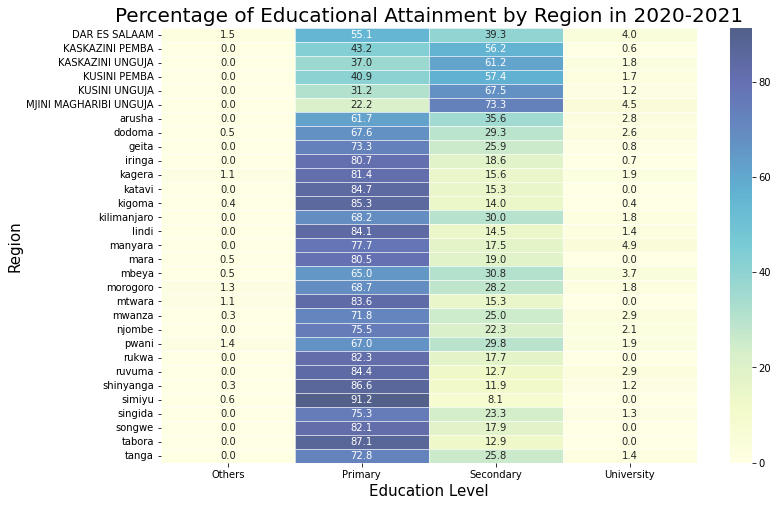

In [7]:
# Education_Region
plt.figure(figsize=(12, 8))
sns.heatmap(education_attain_by_region_pivot_20, annot=True, fmt=".1f", linewidths=.5, cmap="YlGnBu",alpha = 0.7)
plt.title('Percentage of Educational Attainment by Region in 2020-2021', fontsize=20)
plt.xlabel('Education Level', fontsize=15)
plt.ylabel('Region', fontsize=15)
plt.show()

<ipython-input-8-5ebe560e6241>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='literacy_rate', y='region_name', data=region_literacy_sorted, palette='viridis')


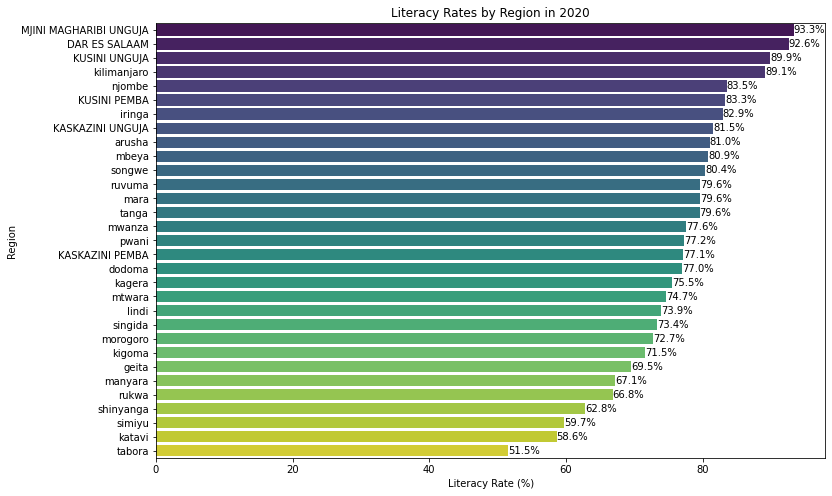

In [8]:
# Literacy
region_literacy = educ_2020.groupby('region_name')['read_wri_kiswa'].mean().reset_index()
region_literacy['literacy_rate'] = region_literacy['read_wri_kiswa'] * 100
region_literacy_sorted = region_literacy.sort_values('literacy_rate', ascending=False)
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='literacy_rate', y='region_name', data=region_literacy_sorted, palette='viridis')
for p in ax.patches:
    width = p.get_width()
    ax.text(width, p.get_y() + p.get_height() / 2, f'{width:.1f}%', ha='left', va='center')

plt.title('Literacy Rates by Region in 2020')
plt.xlabel('Literacy Rate (%)')
plt.ylabel('Region')
plt.show()

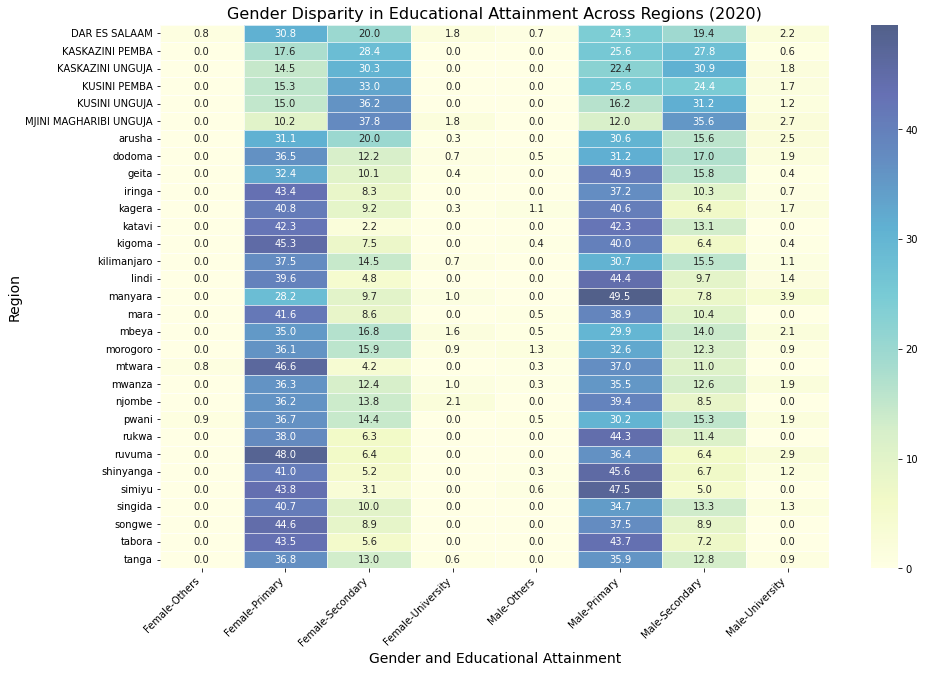

In [9]:
# Gender
educ_attain_cleaned_df = educ_2020.dropna(subset=['educ_attain'])
educ_attain_region_gender_pivot = pd.pivot_table(
    educ_attain_cleaned_df,
    index='region_name',
    columns=['male', 'educ_attain'],
    aggfunc='size',
    fill_value=0 
)

gender_educ_attain_columns = educ_attain_region_gender_pivot.columns.to_list()
gender_mapping = {0: 'Female', 1: 'Male'}
new_columns = [(gender_mapping[gender], educ_attain) for gender, educ_attain in gender_educ_attain_columns]

educ_attain_region_gender_pivot.columns = pd.MultiIndex.from_tuples(new_columns)
educ_attain_region_gender_percentage = educ_attain_region_gender_pivot.div(
    educ_attain_region_gender_pivot.sum(axis=1), axis=0) * 100


plt.figure(figsize=(15, 10))
sns.heatmap(educ_attain_region_gender_percentage, annot=True, fmt=".1f", linewidths=.5, cmap="YlGnBu", alpha = 0.7)
plt.title('Gender Disparity in Educational Attainment Across Regions (2020)', fontsize=16)
plt.xlabel('Gender and Educational Attainment', fontsize=14)
plt.ylabel('Region', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# Group the data by rural/urban and education attainment
education_attain_by_area_20 = educ_2020.groupby(['rural', 'educ_attain']).size().reset_index(name='count')
total_counts_per_area_20 = education_attain_by_area_20.groupby('rural')['count'].transform('sum')
education_attain_by_area_20['percentage'] = (education_attain_by_area_20['count'] / total_counts_per_area_20) * 100
education_attain_by_area_pivot_20 = education_attain_by_area_20.pivot(index='rural', columns='educ_attain', values='percentage').fillna(0)
education_attain_by_area_pivot_20.head()

educ_attain,Others,Primary,Secondary,University
rural,,,,
0,0.610445,49.581732,45.896450,3.911372
1,0.309151,80.729596,18.363561,0.597692


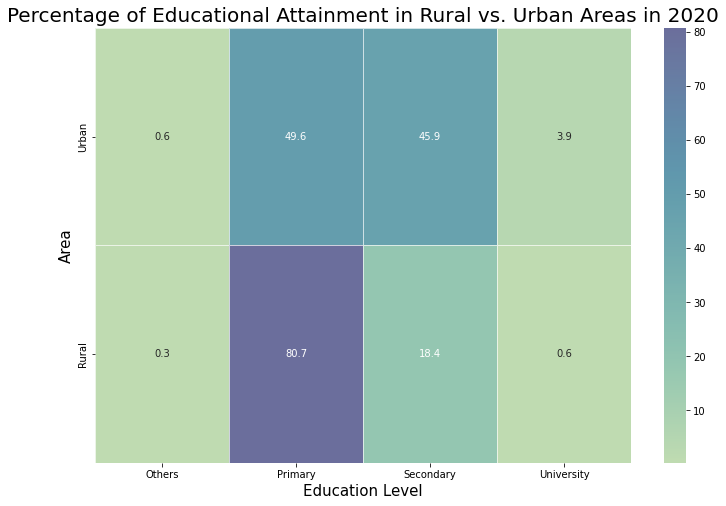

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(education_attain_by_area_pivot_20, annot=True, fmt=".1f", linewidths=.5, cmap="crest",alpha = 0.7)
plt.title('Percentage of Educational Attainment in Rural vs. Urban Areas in 2020', fontsize=20)
plt.xlabel('Education Level', fontsize=15)
plt.ylabel('Area', fontsize=15)
plt.yticks([0.5, 1.5], ['Urban', 'Rural'])
plt.show()

In [12]:
# Absent_reasons for never attend
absent_reasons_by_region = educ_2020.groupby(['region_name', 'never_attend_reason']).size().reset_index(name='count')

absent_reasons_by_region_pivot = absent_reasons_by_region.pivot(index='region_name', columns='never_attend_reason', values='count').fillna(0)

total_absences_per_region = absent_reasons_by_region_pivot.sum(axis=1)

absent_reasons_by_region_percent = (absent_reasons_by_region_pivot.T / total_absences_per_region).T * 100

absent_reasons_by_region_percent.head()

never_attend_reason,DEATH OF PARENT(S),DOES NOT HAVE INTEREST,LACK OF MONEY,OTHER (SPECIFY),PARENTS DO NOT THINK IT IS IMPORTANT,SEPARATION OF PARENTS,TOO EXPENSIVE,TOO FAR AWAY,TOO YOUNG,WORKING (AT HOME OR AT A JOB),disability,illness
region_name,,,,,,,,,,,,
DAR ES SALAAM,2.173913,1.086957,9.782609,7.608696,47.826087,3.26087,0.000000,3.260870,16.304348,2.173913,3.26087,3.260870
KASKAZINI PEMBA,0.000000,0.000000,4.878049,8.536585,79.268293,0.00000,0.000000,0.000000,4.878049,0.000000,0.00000,2.439024
KASKAZINI UNGUJA,0.000000,0.000000,2.173913,2.173913,89.130435,0.00000,2.173913,2.173913,0.000000,0.000000,0.00000,2.173913
KUSINI PEMBA,0.000000,0.000000,2.325581,9.302326,86.046512,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,2.325581
KUSINI UNGUJA,0.000000,0.000000,11.111111,11.111111,77.777778,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


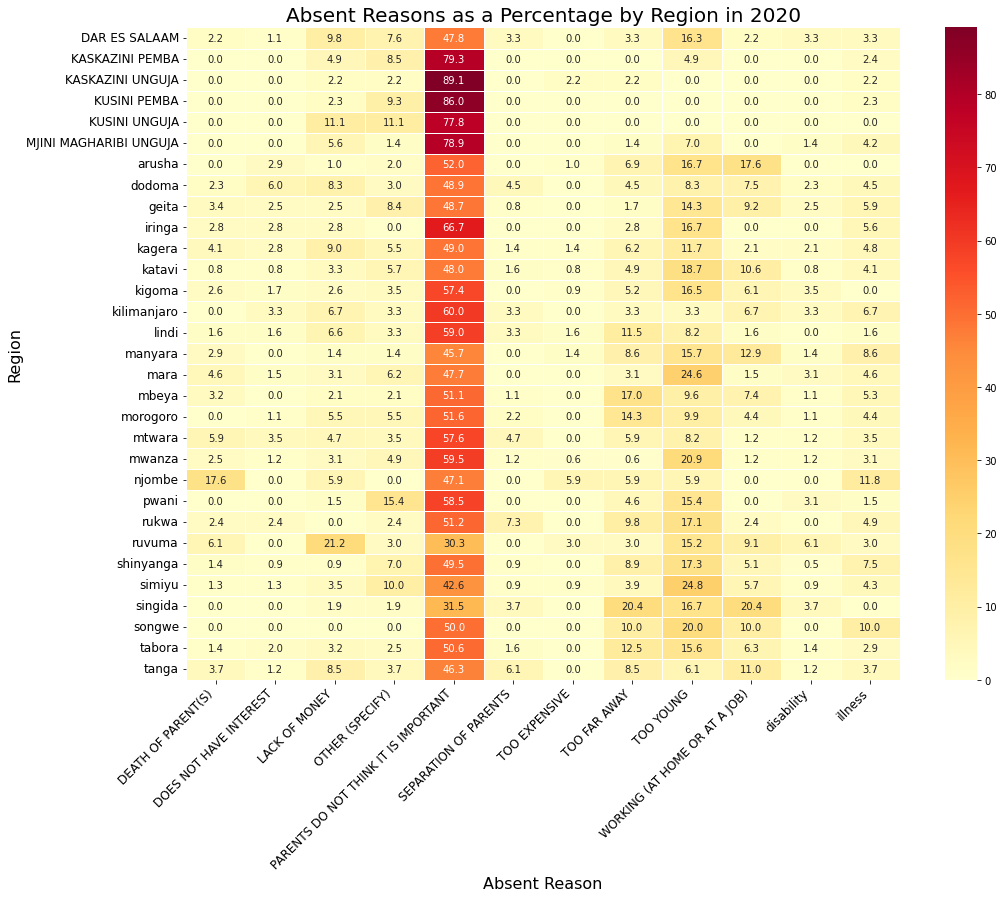

In [13]:
plt.figure(figsize=(16, 12))
sns.heatmap(absent_reasons_by_region_percent, annot=True, fmt=".1f", linewidths=.5, cmap="YlOrRd")


plt.title('Absent Reasons as a Percentage by Region in 2020', fontsize=20)
plt.xlabel('Absent Reason', fontsize=16)
plt.ylabel('Region', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)


plt.show()

In [14]:
# Primary shcool Leaving Exam_PASS
psle_pass_summary = educ_2020['pass_psle'].describe()
print(psle_pass_summary)

psle_pass_counts = educ_2020['pass_psle'].value_counts()
print(psle_pass_counts)

count    8991.000000
mean        0.560783
std         0.496319
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: pass_psle, dtype: float64
pass_psle
1.0    5042
0.0    3949
Name: count, dtype: int64


In [16]:
# K-NN
# For future policy implementation prediction
# could consider features from four dimensions: personal profile, parents profile, school provision & infrastructure, family costs and willingess

features = [
    'male', 'father_educ', 'mother_educ', 'cur_married', 'rural',
    'start_school_age', 'board', 'public', 'time_to_school',
    'free_meal_school', 'access_textbook', 'school_fee', 'book_mat',
    'uniform_fee', 'meal_cost', 'transport_fee', 'extra_tuition'
]
target = 'pass_psle'


mode_value = educ_2020[target].mode()[0]
educ_2020[target] = educ_2020[target].fillna(mode_value)


X = educ_2020[features]
y = educ_2020[target]


categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = list(set(X.columns) - set(categorical_cols))


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str))),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


knn_model = KNeighborsClassifier()

knn_model.fit(X_train_preprocessed, y_train)

y_pred = knn_model.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



Accuracy: 0.802500529773257
Precision: 0.8653562653562653
Recall: 0.901689708141321
F1 Score: 0.8831494483450351


In [17]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

tree_model.fit(X_train_preprocessed, y_train)

y_pred = tree_model.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8287772833227379
Precision: 0.8612406716417911
Recall: 0.945468509984639
F1 Score: 0.9013912618989506


In [28]:
# Random Forest

combined_df = pd.concat([educ_2014, educ_2020], ignore_index=True)


features = [
    'male', 'father_educ', 'mother_educ', 'cur_married', 'rural',
    'start_school_age', 'board', 'public', 'time_to_school',
    'free_meal_school', 'access_textbook', 'school_fee', 'book_mat',
    'uniform_fee', 'meal_cost', 'eduction_expendit_12m'
]
target = 'pass_psle'


mode_value = combined_df['pass_psle'].mode()[0]
combined_df['pass_psle'] = combined_df['pass_psle'].fillna(mode_value)

X = combined_df[features]
y = combined_df[target]


categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = list(set(X.columns) - set(categorical_cols))


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str))),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_preprocessed, y_train)


y_pred = random_forest_model.predict(X_test_preprocessed)


mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")


feature_importances = random_forest_model.feature_importances_
categorical_features_transformed = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_features_transformed = np.concatenate([numerical_cols, categorical_features_transformed])
feature_importance_df = pd.DataFrame({
    'Feature': all_features_transformed,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))



MAE: 0.21752724155279002
RMSE: 0.3394128942350066
R^2: 0.22343210146476367
                            Feature  Importance
0                  start_school_age    0.309241
1425      eduction_expendit_12m_0.0    0.199201
6                    time_to_school    0.101697
4                       cur_married    0.093161
3059  eduction_expendit_12m_missing    0.038873
3                       father_educ    0.036926
10                      mother_educ    0.036443
1                             rural    0.029514
7                              male    0.025355
814                book_mat_missing    0.006225
